In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from nltk.stem.wordnet import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import LSTM, Dense, Bidirectional
from tensorflow.keras.layers import Dropout, SpatialDropout1D, TimeDistributed,Flatten, GlobalMaxPool1D
from tensorflow.keras.layers import Embedding
from keras.layers import multiply
import seaborn as sns
import matplotlib.pyplot as plt

import re
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#importing the dataset

train_data = pd.read_csv('/content/drive/MyDrive/train.csv/train.csv')
test_data = pd.read_csv("/content/drive/MyDrive/train.csv/test.csv",engine='python')

In [5]:
train_data.head(10)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1
6,6,13,14,Should I buy tiago?,What keeps childern active and far from phone ...,0
7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1
8,8,17,18,When do you use シ instead of し?,"When do you use ""&"" instead of ""and""?",0
9,9,19,20,Motorola (company): Can I hack my Charter Moto...,How do I hack Motorola DCX3400 for free internet?,0


In [6]:
test_data.head(10)

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?
5,5,How are the two wheeler insurance from Bharti ...,I admire I am considering of buying insurance ...
6,6,How can I reduce my belly fat through a diet?,How can I reduce my lower belly fat in one month?
7,7,"By scrapping the 500 and 1000 rupee notes, how...",How will the recent move to declare 500 and 10...
8,8,What are the how best books of all time?,What are some of the military history books of...
9,9,After 12th years old boy and I had sex with a ...,Can a 14 old guy date a 12 year old girl?


In [7]:
# taking a fraction of dataset because the whole data set is to large

train_data = train_data.sample(frac=0.1).reset_index(drop=True)
test_data = test_data.sample(frac=0.01).reset_index(drop=True)

In [8]:
train_data.shape, test_data.shape

((40429, 6), (23458, 3))

In [ ]:
#basic info on training data
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40429 entries, 0 to 40428
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            40429 non-null  int64 
 1   qid1          40429 non-null  int64 
 2   qid2          40429 non-null  int64 
 3   question1     40429 non-null  object
 4   question2     40429 non-null  object
 5   is_duplicate  40429 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 1.9+ MB


In [ ]:
#basic info on testing data
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23458 entries, 0 to 23457
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   test_id    23458 non-null  int64 
 1   question1  23458 non-null  object
 2   question2  23458 non-null  object
dtypes: int64(1), object(2)
memory usage: 549.9+ KB


In [ ]:
train_data.describe()

,id,qid1,qid2,is_duplicate
count,40429.000000,40429.000000,40429.000000,40429.000000
mean,201829.114423,216465.293057,220474.295629,0.372826
std,116636.752131,157358.542005,159770.474837,0.483562
min,0.000000,1.000000,2.000000,0.000000
25%,101383.000000,73732.000000,74059.000000,0.000000
50%,201693.000000,192316.000000,196723.000000,0.000000
75%,302830.000000,344315.000000,353035.000000,1.000000
max,404289.000000,537932.000000,537933.000000,1.000000


In [ ]:
test_data.describe()

,test_id
count,2.345800e+04
mean,1.176354e+06
std,6.768838e+05
min,3.400000e+01
25%,5.905488e+05
50%,1.180543e+06
75%,1.761304e+06
max,2.345768e+06


In [ ]:
#dropping 'id','qid1','qid2' from training dataset
#dropping 'test_id' from testing dataset

train_data = train_data.drop(['id','qid1','qid2'],axis=1)
test_data = test_data.drop(['test_id'],axis=1)
train_data.head(10)

,question1,question2,is_duplicate
0,Why doesn't everyone I ask to answer a questio...,Why does no body answer my question in Quora?,1
1,How do I get funding to turn my idea into a re...,How can I get funding for my invention ideas?,1
2,What is the best way to get over your ex?,How can I get over my ex?,0
3,What's the most scenic driving route from Dall...,What's the most scenic driving route from Aust...,1
4,What is a good way to get over depression?,How do I help a depressed person to get over it?,1
5,How do you write an excuse letter for being ab...,How do you write a letter to your child's scho...,0
6,How do I apply machine learning in business?,How do I apply machine learning to business?,1
7,What are your top 5 funniest movies of all time?,What were the best movies of 2016? Why?,0
8,What Quora mean?,"What does ""Quora"" mean?",1
9,What are some things you would like to read ab...,What does it feel like to win a competition?,0


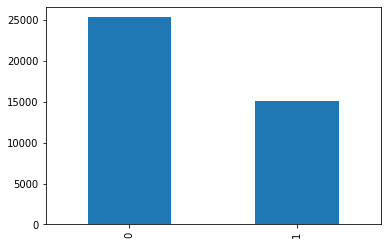

In [ ]:
#plot of duplicate questions
train_data.is_duplicate.value_counts().plot(kind='bar')

In [ ]:
train_data[train_data['is_duplicate']==1].shape,train_data[train_data['is_duplicate']==0].shape

((15073, 3), (25356, 3))

In [ ]:
is_duplicate = train_data[train_data['is_duplicate']==1]
not_duplicate = train_data[train_data['is_duplicate']==0].sample(14798)

In [ ]:
train_data = pd.concat([is_duplicate,not_duplicate])
train_data = train_data.sample(frac=1).reset_index(drop=True)
train_data

,question1,question2,is_duplicate
0,How much money does the owner/operator of a si...,"How much money does Wham make from ""Last Chris...",0
1,What is the best website or job portal for fre...,Which are the best job portals for a post grad...,0
2,What is the game engine used for the game 7Sins?,Do I handicap myself by using 3rd Party Game e...,0
3,How do I get my husband d to understand that i...,I am 23 years old and want to move out of my m...,0
4,"How do you say ""I'm sorry"" in Korean? Is there...",How can I say 'Hello' in Korean?,0
...,...,...,...
29866,"I don't have a proof of address, how do I appl...",How can I apply online for issuance of PAN car...,1
29867,How do I ignore what other people think of me?,Should I care what people think about me? Most...,1
29868,Why did Germany attacked Russia?,How do transfer money from Thailand to Chennai...,0
29869,Who were the founders of DealBase.com?,Who is the founder of Waygook.org?,0


In [ ]:
train_data = pd.concat([is_duplicate,not_duplicate])
train_data = train_data.sample(frac=1).reset_index(drop=True)
train_data

,question1,question2,is_duplicate
0,Did the Indian government ban the 500 Rs & 100...,Why did the Indian government demonetize the c...,1
1,What do software engineering interns do?,What is it like to be a software engineering i...,0
2,What are the best ways to make a fool of yours...,A worker who sits next to me in a cubicle make...,0
3,"If you feel disappointed in yourself, how do y...",How do you make yourself feel better?,0
4,How can I earn money through YouTube?,How can I earn money in YouTube?,1
...,...,...,...
29866,What is the best way to prepare for TOEFL?,What is the best way to prepare for taking the...,1
29867,What would make you talk with your phone in pu...,How is German history taught in Germany?,0
29868,What is the best answer according to you when ...,"What are the best answers for ""Why you want to...",1
29869,How effective are the current methods of detec...,How effective are current methods of detecting...,1


In [ ]:
train_data = pd.concat([is_duplicate,not_duplicate])
train_data = train_data.sample(frac=1).reset_index(drop=True)
train_data

,question1,question2,is_duplicate
0,How do I fix an iPhone 4 camera?,How do you fix an iPhone camera that doesn't o...,0
1,Why is there political instability in Nigeria?,What are the causes for political instability ...,1
2,How can I delete my Instagram account when I f...,If I forgot both my username and password of m...,0
3,What is the meaning of automation?,What is mean by automation?,1
4,How do I get rid of electoral college?,How can we get rid of the electoral college?,1
...,...,...,...
29866,What is universal meter in electronics?,What are the top universities to pursue MS in ...,0
29867,How do atheists explain the Shroud of Turin?,What do you think about the Shroud of Turin?,1
29868,What is a UCC 1 Financing Statement?,What is a UCC Finance Statement?,0
29869,What is the purpose of sleeping and dreaming?,What is the purpose of dreaming?,1


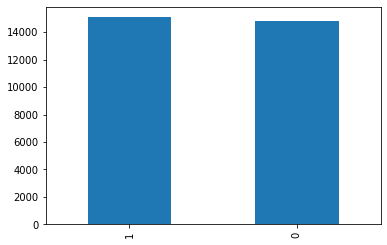

In [ ]:
#plotting the duplicate column again after processing the data
train_data.is_duplicate.value_counts().plot(kind='bar')

In [ ]:
#Lemmatize Words

def get_pos_tag(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        # As default pos in lemmatization is Noun
        return wordnet.NOUN

lemmatizer = WordNetLemmatizer()

In [ ]:
#cleaning the data now 
import nltk
nltk.download('stopwords')
regex = [
    r'<[^>]+>', #HTML tags
    r'@(\w+)', # @-mentions
    r"#(\w+)", # hashtags
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', # URLs
    r'[^0-9a-z #+_\\r\\n\\t]', #BAD SYMBOLS
]

REPLACE_URLS = re.compile(r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+')
REPLACE_HASH = re.compile(r'#(\w+)')
REPLACE_AT = re.compile(r'@(\w+)')
REPLACE_HTML_TAGS = re.compile(r'<[^>]+>')
#REPLACE_DIGITS = re.compile(r'\d+')
#REPLACE_BY = re.compile(r"[/(){}\[\]\|,;.:?\-\'\"$]")
REPLACE_BY = re.compile(r"[^a-z0-9\-]")

STOPWORDS = set(stopwords.words('english'))

#tokens_re = re.compile(r'('+'|'.join(regex)+')', re.VERBOSE | re.IGNORECASE)

# sentences = [] #for Word2Vec model
def clean_text(text):
    text = text.lower()
    text = REPLACE_HTML_TAGS.sub(' ', text)
    text = REPLACE_URLS.sub('', text)
    text = REPLACE_HASH.sub('', text)
    text = REPLACE_AT.sub('', text)
    #text = REPLACE_DIGITS.sub(' ', text)
    text = REPLACE_BY.sub(' ', text)
    
    
    text = " ".join(lemmatizer.lemmatize(word.strip(), get_pos_tag(pos_tag([word.strip()])[0][1])) 
               for word in text.split() if word not in STOPWORDS and len(word)>3)
    
    #sentences.append(text.split())
    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#importing the nltk classes and testing get_pos_tag function
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
get_pos_tag(pos_tag(['playing'.strip()])[0][1])

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


'v'

In [ ]:
nltk.download('averaged_perceptron_tagger')
pos_tag(['word'.strip()])

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


[('word', 'NN')]

In [ ]:
lemmatizer.lemmatize('playing'.strip(), get_pos_tag(pos_tag(['playing'.strip()])[0][1]))

'play'

In [ ]:
get_pos_tag(pos_tag(['playing'.strip()])[0][1])

'v'

In [ ]:
lemmatizer.lemmatize('playable'.strip(),'v' )

'playable'

In [ ]:
#applying the clean_text function to train_data

train_data['q1'] = train_data['question1'].apply(clean_text)
train_data['q2'] = train_data['question2'].apply(clean_text)

In [ ]:
train_data.head(10)

,question1,question2,is_duplicate,q1,q2
0,How do I fix an iPhone 4 camera?,How do you fix an iPhone camera that doesn't o...,0,iphone camera,iphone camera open
1,Why is there political instability in Nigeria?,What are the causes for political instability ...,1,political instability nigeria,cause political instability nigeria
2,How can I delete my Instagram account when I f...,If I forgot both my username and password of m...,0,delete instagram account forgot password email,forgot username password instagram account del...
3,What is the meaning of automation?,What is mean by automation?,1,meaning automation,mean automation
4,How do I get rid of electoral college?,How can we get rid of the electoral college?,1,electoral college,electoral college
5,What are the best artificial intelligence tuto...,How does it feel when you reach the age at whi...,0,best artificial intelligence tutorial beginner...,feel reach father die
6,Did lead intoxication cause the fall of Roman ...,Did lead poisoning cause the fall of the Roman...,1,lead intoxication cause fall roman empire,lead poison cause fall roman empire
7,Why do people trust Quora?,Should I trust answers on Quora?,0,people trust quora,trust answer quora
8,Did you make your first million$ on your own o...,Did you depend on a college degree to find suc...,0,make first million help,depend college degree find success use resource
9,What are good gifts for a foreign visitor to b...,What are good gifts for a foreign visitor to b...,0,good gift foreign visitor bring invite someone...,good gift foreign visitor bring invite someone...


In [ ]:
#applying the clean_text function to train_data

test_data['q1'] = test_data['question1'].apply(clean_text)
test_data['q2'] = test_data['question2'].apply(clean_text)
test_data.head(10)

,question1,question2,q1,q2
0,What have you social security number online?,How can mentor find out what my social securit...,social security number online,mentor find social security number online free
1,What are the job opportunities in updated indi...,What are the job opportunities anxieties for M...,opportunity update india,opportunity anxiety marketing india
2,What motivates Vladimir?,What do you people think t of Vladimir Putin?,motivates vladimir,people think vladimir putin
3,What is the difference between song and MP3?,What is the difference between 128 kbps and 32...,difference song,difference kbps kbps file
4,What dear it like to be smart?,What is it like to english smart yet naive?,dear like smart,like english smart naive
5,Which are the manga elie episodes in 'Naruto S...,When is the release of Naruto president Episod...,manga elie episode naruto shippuden anime,release naruto president episode english site
6,"What does ""all I want for my birthday is a big...",How do I do Pandora better than Pandora? What ...,want birthday mean,pandora well pandora want people match music b...
7,How much would it cost to live find in Chiang ...,What are good strategies to finding ceiba apar...,much would cost live find chiang thailand month,good strategy find ceiba apartment baht chiang...
8,What is men more attractive than Asian men?,Why are white women not interested in dating A...,attractive asian,white woman interested date asian attractive
9,I'm a first year in computer science engineeri...,Which laptop should few I buy as a Computer Sc...,first year computer science engineering studen...,laptop computer science programmer


In [ ]:
#max len of clean data

max_len_q1 = np.max(train_data["q1"].apply(lambda x: len(x.split())))
max_len_q2 = np.max(train_data["q2"].apply(lambda x: len(x.split())))
max_len_q1, max_len_q2

(27, 90)

In [ ]:
MAX_NB_WORDS = 200000
#initialzing the Tokenizer
tokenizer = Tokenizer(num_words = MAX_NB_WORDS)

tokenizer.fit_on_texts(list(train_data['q1'].values.astype(str))+list(train_data['q2'].values.astype(str)))

# converting the text to sequences and add padding
X_train_q1 = tokenizer.texts_to_sequences(train_data['q1'].values.astype(str))
X_train_q1 = pad_sequences(X_train_q1, maxlen = 30, padding = 'post')

X_train_q2 = tokenizer.texts_to_sequences(train_data['q2'].values.astype(str))
X_train_q2 = pad_sequences(X_train_q2, maxlen = 30, padding = 'post')

In [ ]:
#repeating the above process for test_data

X_test_q1 = tokenizer.texts_to_sequences(test_data['q1'].ravel())
X_test_q1 = pad_sequences(X_test_q1,maxlen = 30, padding='post')

X_test_q2 = tokenizer.texts_to_sequences(test_data['q2'].astype(str).ravel())
X_test_q2 = pad_sequences(X_test_q2, maxlen = 30, padding='post')

In [ ]:
y = train_data['is_duplicate']

In [ ]:
vocab_size = len(tokenizer.word_index) + 1

#Loading Glove word embedding

GloVe is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space.

In [ ]:
#opeining the glove embedding file 

embeddings_index = {}
glovefile = open('/content/drive/MyDrive/train.csv/glove.6B.200d.txt','r',encoding='utf-8')
for line in tqdm(glovefile):
    values = line.split(" ")
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
#     coefs.shape
    embeddings_index[word] = coefs
glovefile.close()

print('Found %s word vectors.' % len(embeddings_index))

400000it [00:29, 13453.34it/s]

Found 400000 word vectors.


In [ ]:
#creating embedding matrix for the words we have in the dataset
embedding_matrix = np.zeros((len(tokenizer.word_index)+1, 200))
for words, index in tqdm(tokenizer.word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

100%|██████████| 18358/18358 [00:00<00:00, 663293.01it/s]


In [ ]:
X_train_q1,X_valid_q1, X_train_q2, X_valid_q2, y_train, y_valid = train_test_split(X_train_q1, X_train_q2, y, test_size=0.20, random_state=12)
print(X_train_q1.shape, X_train_q2.shape, y_train.shape)
print(X_valid_q1.shape, X_valid_q2.shape, y_valid.shape)

(23896, 30) (23896, 30) (23896,)
(5975, 30) (5975, 30) (5975,)


In [ ]:
# Model for Q1

model_q1 = Sequential([Embedding(input_dim = vocab_size,output_dim = 200,weights = [embedding_matrix],input_length = 30),
                      LSTM(128, activation = 'tanh', return_sequences = True),
                      Dropout(0.2),
                      LSTM(128, return_sequences = True),
                      LSTM(128),
                      Dense(60, activation = 'tanh'),
                      Dense(2, activation = 'sigmoid')])

In [ ]:
# Model for Q2

model_q2 = Sequential([Embedding(input_dim = vocab_size,output_dim = 200,weights = [embedding_matrix],input_length = 30),
                      LSTM(128, activation = 'tanh', return_sequences = True),
                      Dropout(0.2),
                      LSTM(128, return_sequences = True),
                      LSTM(128),
                      Dense(60, activation = 'tanh'),
                      Dense(2, activation = 'sigmoid')])

In [ ]:
# Merging the output of the two models,i.e, model_q1 and model_q2
mergedOut = multiply([model_q1.output, model_q2.output])

mergedOut = Flatten()(mergedOut)
mergedOut = Dense(100, activation = 'relu')(mergedOut)
mergedOut = Dropout(0.2)(mergedOut)
mergedOut = Dense(50, activation = 'relu')(mergedOut)
mergedOut = Dropout(0.2)(mergedOut)
mergedOut = Dense(2, activation = 'sigmoid')(mergedOut)

In [ ]:
new_model = tf.keras.Model([model_q1.input, model_q2.input], mergedOut)
new_model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy',
                 metrics = ['accuracy'])

In [ ]:
new_model = tf.keras.Model([model_q1.input, model_q2.input], mergedOut)
new_model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy',
                 metrics = ['accuracy'])

In [ ]:
new_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 embedding_input (InputLayer)   [(None, 30)]         0           []                               
                                                                                                  
 embedding_1_input (InputLayer)  [(None, 30)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 30, 200)      3671800     ['embedding_input[0][0]']        
                                                                                                  
 embedding_1 (Embedding)        (None, 30, 200)      3671800     ['embedding_1_input[0][0]']      
                                                                                            

In [ ]:
history = new_model.fit([X_train_q1,X_train_q2],y_train, batch_size = 2000, epochs = 20, validation_data = ([X_valid_q1,X_valid_q2],y_valid))

Epoch 1/20
12/12 [==============================] - 113s 9s/step - loss: 0.6920 - accuracy: 0.5283 - val_loss: 0.6858 - val_accuracy: 0.5864
Epoch 2/20
12/12 [==============================] - 99s 8s/step - loss: 0.6818 - accuracy: 0.5772 - val_loss: 0.6889 - val_accuracy: 0.5168
Epoch 3/20
12/12 [==============================] - 97s 8s/step - loss: 0.6896 - accuracy: 0.5152 - val_loss: 0.6808 - val_accuracy: 0.5628
Epoch 4/20
12/12 [==============================] - 97s 8s/step - loss: 0.6885 - accuracy: 0.5287 - val_loss: 0.6809 - val_accuracy: 0.5623
Epoch 5/20
12/12 [==============================] - 97s 8s/step - loss: 0.6824 - accuracy: 0.5565 - val_loss: 0.6781 - val_accuracy: 0.5697
Epoch 6/20
12/12 [==============================] - 97s 8s/step - loss: 0.6775 - accuracy: 0.5770 - val_loss: 0.6751 - val_accuracy: 0.5863
Epoch 7/20
12/12 [==============================] - 97s 8s/step - loss: 0.6636 - accuracy: 0.6093 - val_loss: 0.6682 - val_accuracy: 0.5843
Epoch 8/20
12/12 [=

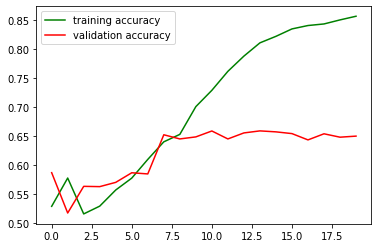

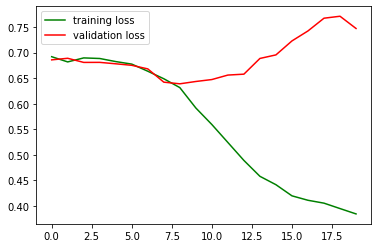

In [ ]:
accuracy = history.history["accuracy"]
loss = history.history["loss"]

val_accuracy = history.history["val_accuracy"]
val_loss = history.history["val_loss"]

#plot 
plt.plot(accuracy,'g',label='training accuracy')
plt.plot(val_accuracy, 'r', label='validation accuracy')
plt.legend()
plt.show()


plt.plot(loss,'g',label='training loss')
plt.plot(val_loss, 'r', label='validation loss')
plt.legend()
plt.show()

In [ ]:
y_pred = new_model.predict([X_test_q1, X_test_q2])

In [ ]:
np.argmax(y_pred[:10], axis=-1)

array([0, 1, 1, 0, 1, 0, 0, 0, 1, 1])

#Now using BERT model for solving the problem

In [9]:
import numpy as np
import pandas as pd
import tensorflow as tf
!pip install transformers==2.11.0
import transformers

     |████████████████████████████████| 674 kB 5.4 MB/s 
     |████████████████████████████████| 895 kB 47.7 MB/s 
     |████████████████████████████████| 5.6 MB 40.2 MB/s 
     |████████████████████████████████| 1.2 MB 41.3 MB/s 


In [10]:
!pip install transformers==2.11.0
import transformers

In [11]:
max_length = 128  # Maximum length of input sentence to the model.
batch_size = 32
epochs = 2

# Labels in our dataset.
labels = [1,0]
df=train_data

In [12]:
print(df.isnull().sum(axis=0))#Dropiing Null values
df.dropna(axis=0,inplace=True)

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64


In [13]:
mask = np.random.rand(len(df)) < 0.7
train_df = df[mask]
not_train = df[~mask]

#create mask for val-test distribution
mask = np.random.rand(len(not_train)) < 0.5
test_df = not_train[mask]
val_df = not_train[~mask]
val_df.head(5)

,id,qid1,qid2,question1,question2,is_duplicate
6,227940,336895,14677,How can I make friends with kids?,How can you make friends with people?,0
13,112587,184184,184185,When will China be free?,What is a primer and sealer?,0
20,370440,13002,53214,What are the best books for preparation of gat...,Which are the best books for GATE?,1
30,175300,79364,269940,How many beats per minute is allegro?,How many music producers in the world make +$1...,0
37,250664,364621,364622,Is French hard to learn?,Is it hard to learn French?,1


In [14]:
print(f"Total train samples : {train_df.shape[0]}")
print(f"Total validation samples: {val_df.shape[0]}")
print(f"Total test samples: {test_df.shape[0]}")

Total train samples : 28243
Total validation samples: 6116
Total test samples: 6070


In [15]:
print("Train Target Distribution")
print(train_df.is_duplicate.value_counts())

print("Validation Target Distribution")
print(val_df.is_duplicate.value_counts())


Train Target Distribution
0    17764
1    10479
Name: is_duplicate, dtype: int64
Validation Target Distribution
0    3857
1    2259
Name: is_duplicate, dtype: int64


In [16]:
y_train = tf.keras.utils.to_categorical(train_df.is_duplicate, num_classes=2)#One hot encodding representation
print(f"y_train.shape:{y_train.shape}")

y_val = tf.keras.utils.to_categorical(val_df.is_duplicate, num_classes=2)
print(f"y_val.shape:{y_val.shape}")

y_test = tf.keras.utils.to_categorical(test_df.is_duplicate, num_classes=2)
print(f"y_test.shape:{y_test.shape}")

y_train.shape:(28243, 2)
y_val.shape:(6116, 2)
y_test.shape:(6070, 2)


In [17]:
class BertSemanticDataGenerator(tf.keras.utils.Sequence):
  def __init__(
        self,
        sentence_pairs,
        labels,
        batch_size=batch_size,
        shuffle=True,
        include_targets=True,
    ):
        self.sentence_pairs = sentence_pairs
        self.labels = labels
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.include_targets = include_targets
        
        # Load our BERT Tokenizer to encode the text.
        # We will use base-base-uncased pretrained model.
        self.tokenizer = transformers.BertTokenizer.from_pretrained(
            "bert-base-uncased", do_lower_case=True
        )
        self.indexes = np.arange(len(self.sentence_pairs))
        self.on_epoch_end()

  def __len__(self):
        # Denotes the number of batches per epoch.
        return len(self.sentence_pairs) // self.batch_size

  def __getitem__(self, idx):
        # Retrieves the batch of index.
        indexes = self.indexes[idx * self.batch_size : (idx + 1) * self.batch_size]
        sentence_pairs = self.sentence_pairs[indexes]

        # With BERT tokenizer's batch_encode_plus batch of both the sentences are
        # encoded together and separated by [SEP] token.
        encoded = self.tokenizer.batch_encode_plus(
            sentence_pairs.tolist(),
            add_special_tokens=True,
            max_length=max_length,
            return_attention_mask=True,
            return_token_type_ids=True,
            pad_to_max_length=True,
            return_tensors="tf",
        )

        # Convert batch of encoded features to numpy array.
        input_ids = np.array(encoded["input_ids"], dtype="int32")
        attention_masks = np.array(encoded["attention_mask"], dtype="int32")
        token_type_ids = np.array(encoded["token_type_ids"], dtype="int32")

        # Set to true if data generator is used for training/validation.
        if self.include_targets:
            labels = np.array(self.labels[indexes], dtype="int32")
            return [input_ids, attention_masks, token_type_ids], labels
        else:
            return [input_ids, attention_masks, token_type_ids]

  def on_epoch_end(self):
        # Shuffle indexes after each epoch if shuffle is set to True.
        if self.shuffle:
            np.random.RandomState(42).shuffle(self.indexes)

In [18]:
strategy = tf.distribute.MirroredStrategy()# Create the model under a distribution strategy scope.

with strategy.scope():
    # Encoded token ids from BERT tokenizer.
    input_ids = tf.keras.layers.Input(
        shape=(max_length,), dtype=tf.int32, name="input_ids"
    )
    # Attention masks indicates to the model which tokens should be attended to.
    attention_masks = tf.keras.layers.Input(
        shape=(max_length,), dtype=tf.int32, name="attention_masks"
    )
    # Token type ids are binary masks identifying different sequences in the model.
    token_type_ids = tf.keras.layers.Input(
        shape=(max_length,), dtype=tf.int32, name="token_type_ids"
    )
    # Loading pretrained BERT model.
    bert_model = transformers.TFBertModel.from_pretrained("bert-base-uncased")
    # Freeze the BERT model to reuse the pretrained features without modifying them.
    bert_model.trainable = False

    sequence_output, pooled_output = bert_model(
        input_ids, attention_mask=attention_masks, token_type_ids=token_type_ids
    )
    # Add trainable layers on top of frozen layers to adapt the pretrained features on the new data.
    bi_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(sequence_output)
    
    # Applying hybrid pooling approach to bi_lstm sequence output.
    avg_pool = tf.keras.layers.GlobalAveragePooling1D()(bi_lstm)
    max_pool = tf.keras.layers.GlobalMaxPooling1D()(bi_lstm)
    concat = tf.keras.layers.concatenate([avg_pool, max_pool])
    dropout = tf.keras.layers.Dropout(0.3)(concat)
    output = tf.keras.layers.Dense(2, activation="softmax")(dropout)
    model = tf.keras.models.Model(
        inputs=[input_ids, attention_masks, token_type_ids], outputs=output
    )

    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss="categorical_crossentropy",
        metrics=["acc"],
    )


print(f"Strategy: {strategy}")
model.summary()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/536M [00:00<?, ?B/s]

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Strategy: <tensorflow.python.distribute.mirrored_strategy.MirroredStrategy object at 0x7f42193c5ad0>
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                           

In [19]:
train_data = BertSemanticDataGenerator(
    train_df[["question1", "question2"]].values.astype("str"),
    y_train,
    batch_size=batch_size,
    shuffle=True,
)
val_data = BertSemanticDataGenerator(
    val_df[["question1", "question2"]].values.astype("str"),
    y_val,
    batch_size=batch_size,
    shuffle=False,
)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [20]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=1,
     use_multiprocessing=True,
    workers=-1,
)

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
882/882 [==============================] - 808s 891ms/step - loss: 0.4825 - acc: 0.7509 - val_loss: 0.4383 - val_acc: 0.7958


In [21]:
bert_model.trainable = True
# Recompile the model to make the change effective.
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 attention_masks (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    ((None, 128, 768),   109482240   ['input_ids[0][0]',              
                                 (None, 768))                     'attention_masks[0][0]',    

In [22]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=1,
    use_multiprocessing=True,
    workers=-1,
)

882/882 [==============================] - 1855s 2s/step - loss: 0.3792 - accuracy: 0.8188 - val_loss: 0.3346 - val_accuracy: 0.8496


In [23]:
test_data = BertSemanticDataGenerator(
    test_df[["question1", "question2"]].values.astype("str"),
    y_test,
    batch_size=batch_size,
    shuffle=False,
)
model.evaluate(test_data, verbose=1)

189/189 [==============================] - 125s 661ms/step - loss: 0.3475 - accuracy: 0.8438


[0.3474774658679962, 0.84375]

In [30]:
def check_similarity(sentence1, sentence2):
  sentence_pairs = np.array([[str(sentence1), str(sentence2)]])
  test_data = BertSemanticDataGenerator(
      sentence_pairs, labels=None, batch_size=1, shuffle=False, include_targets=False,
  )

  proba = model.predict(test_data)[0]
  idx = np.argmax(proba)
  proba = f"{proba[idx]: .2f}%"
  pred = labels[idx]
  return pred, proba